## 2. Importing Libraries

In [1]:
# Colab specific
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')

Mounted at /content/drive


In [2]:
!pip install biopython
from IPython import get_ipython
from IPython.display import display
!pip install ete3
!pip install pyqt5
!pip install dendropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273787 sha256=5a9dfc92577121d50940db96f013a11473eaf758486d2b2fb32c6ba6bc0136ff
  Stored in directory: /root/.cache/pip/wheels/dd/a8/60/0a29caa9f8ceb7316704be63c1578ab13c36668abb646366ac
Successfully built ete3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.5/459.5 kB 20.9 MB/s eta 0:00:00


In [3]:
# Standard library imports
import os
import json
import tempfile
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Generator
from dataclasses import dataclass
from math import log
from random import choice
from datetime import datetime
import shutil
import logging
from typing import Tuple, List, Dict
import re

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Biopython imports
from Bio import Entrez, SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.Consensus import majority_consensus

# QIIME2 imports
#import qiime2
#from qiime2.plugins import demux, dada2, phylogeny, alignment, diversity
#import qiime2.plugins.feature_table.methods as feature_table_methods
#import qiime2.plugins.feature_table.visualizers as visualizers

# biom imports
#from biom.table import Table
#from biom.util import biom_open
#from biom import load_table

# Tree visualization imports
from ete3 import (
    Tree as EteTree,  # Renamed to avoid conflict
    TreeStyle,
    NodeStyle,
    TextFace,
    RectFace,
    faces,
    CircleFace
)
import dendropy
from dendropy import Tree as DendroTree  # Renamed to avoid conflict

# Subprocess for external commands
import subprocess

In [22]:
'''# For VSCode
output_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime")
# Create output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)
bootstrap_dir = output_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

input_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime")
original_sequences_file = input_dir / "final_sequences_integrate.fasta"
'''
# for colab
output_dir = data_qiime / "output_dir"
output_dir.mkdir(parents=True, exist_ok=True)

# for colab
abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")
large_dir = Path("/content/drive/MyDrive/MIC/")
input_galaxy = large_dir / "data_galaxies"
data_qiime = Path("/content/drive/MyDrive/MIC/data_qiime")
input_dir = Path("/content/drive/MyDrive/MIC/data_qiime")
newick_path = Path("/content/drive/MyDrive/MIC/data_galaxies/Galaxy7-PICRUSt2-Full-pipeline-on-data-2-and-data-1-Tree-reference-study-16S-sequences.newick")
output_base = Path("/content/drive/MyDrive/MIC/data_picrust/output_base")
tree_path = Path("/content/drive/MyDrive/MIC/data_qiime/consensus_tree_integrated_ncbi.newick")
output_galaxy = input_dir / "output_galaxy"
output_galaxy.mkdir(parents=True, exist_ok=True)

In [9]:
source_type = 'check_core_usual' # made on book 4 directory /data_ref

In [12]:
#selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name='core_taxa', header=[0,1,2,3,4,5,6,7]) # for individual or two combinations activate
selected = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7]) # for the mixture of the 3 df
# Drop first row (index 0) and first column in one chain
selected = selected.drop(index=0).drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# If the dataframe has Nan in sites it will replace it with Source
selected['Sites'] = selected['Sites'].fillna('Source')
# Fill the other index with nothing
selected = selected.fillna(' ')
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T

In [13]:
# First, let's create a new DataFrame with the correct structure
selected_taxa= selected_taxa.reset_index()

# Now, rename the columns
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns = new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

# Now we can create the dictionaries as before
category_dict = selected_taxa.iloc[0, 8:].to_dict()
jointax_dict = selected_taxa[['Genus', 'Jointax']].set_index('Genus')['Jointax'].to_dict()

Taxa should be on multiindex and sites are headers

In [14]:
selected_taxa.head()

,Jointax,Kingdom,Phylum,Class,Order,Family,Genus,GID,site_1,site_2,...,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70,Source
0,Category,,,,,,,,3.0,1.0,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,1.0,
1,Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.85923,...,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0,1.47,1.72,chk-core
2,Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0,0,...,0,0,0,0.054437,0,0,0.021172,0,0,chk
3,Actinomycetales_Brevibacteriaceae_Brevibacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Brevibacteriaceae,Brevibacterium,145,0,0,...,0,0,0,0.217746,0,0,0,0,0,chk
4,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Bacteria,Firmicutes,Erysipelotrichi,Erysipelotrichales,Erysipelotrichaceae,Bulleidia,154,0,0,...,0,0,0,0,0,0,0,0,0,chk


In [15]:
def get_color_scheme(genus_name: str) -> str:
    """
    Color scheme for bacterial categories:
    - checked (chk): #000080 (navy blue)
    - usual (us): #8B0000 (dark red)
    - chk-us: #9370DB (purple)
    - chk-core: #000033 (darker navy)
    - core-us: #654321 (dark brown)
    - chk-core-us: #4A0404 (deep burgundy)
    """
    if 'Source' not in selected_taxa.columns:
        return 'black'

    try:
        genus_source = selected_taxa.loc[selected_taxa['Genus'] == genus_name, 'Source'].iloc[0]
        source = str(genus_source).lower()
        #chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us

        if 'chk-core-us' in source:
            return '#4A0404'  # Deep burgundy for all three
        elif 'chk-core' in source:
            return '#000033'  # Darker navy for checked+core
        elif 'core-us' in source:
            return '#654321'  # Dark brown for core+usual
        elif 'chk-us' in source:
            return '#9370DB'  # Purple for checked+usual
        elif 'chk' in source:
            return '#000080'  # Navy blue for checked only
        elif 'us' in source:
            return '#8B0000'  # Dark red for usual only
        return 'black'

    except (IndexError, KeyError):
        return 'black'
# Define set to track added names
added_names = set()

In [16]:
def build_aggregated_data(selected_taxa, category_dict):
    """
    Aggregate abundance data by category for each genus

    Args:
        selected_taxa (pd.DataFrame): DataFrame with taxa and abundance data
        category_dict (dict): Mapping of sites to categories

    Returns:
        dict: Dictionary mapping genera to their abundance in each category
    """
    # Initialize empty dictionary to store the aggregated data
    aggregated_data = {}

    # Loop through each row in the DataFrame
    for index, row in selected_taxa.iterrows():
        genus = row['Genus'] # Using level_6 for genus
        if genus not in aggregated_data:
            aggregated_data[genus] = {'category_1': 0, 'category_2': 0, 'category_3': 0}

        # Loop through each site column
        site_columns = [col for col in selected_taxa.columns if col.startswith('site_')]
        for site_column in site_columns:
            category = category_dict[site_column]
            abundance = row[site_column]

            if category == 1:
                aggregated_data[genus]['category_1'] += abundance
            elif category == 2:
                aggregated_data[genus]['category_2'] += abundance
            elif category == 3:
                aggregated_data[genus]['category_3'] += abundance

    return aggregated_data

In [39]:
aggregated_data = build_aggregated_data(selected_taxa, category_dict)

In [19]:
def create_tree_visualization(tree_path, aggregated_data, category_colors, categories):
    """
    Creates and styles a phylogenetic tree visualization

    Args:
        tree_path (str): Path to the newick tree file
        aggregated_data (dict): Dictionary of abundance data by genus and category
        category_colors (dict): Color mapping for categories
        categories (dict): Category descriptions

    Returns:
        tuple: (EteTree, TreeStyle) - styled tree and its styling
    """
    # Load the tree
    t = EteTree(tree_path, format=0)

    # Create tree style
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.branch_vertical_margin = 5
    ts.scale = 120
    ts.show_branch_support = False

    # Create node style
    nstyle = NodeStyle()
    nstyle["size"] = 5
    nstyle["fgcolor"] = "#666666"
    nstyle["hz_line_width"] = 2
    nstyle["vt_line_width"] = 2

    # Bootstrap label layout function
    def layout(node):
        if not node.is_leaf():
            if hasattr(node, "support"):
                support_value = node.support * 100 if node.support <= 1 else node.support
                bootstrap_face = TextFace(f"{support_value:.0f}%", fsize=8, fgcolor="braun")
                node.add_face(bootstrap_face, column=0, position="branch-top")

    ts.layout_fn = layout

    # Track added names
    added_names = set()

    # Apply style and add annotations
    for node in t.traverse():
        if node.is_leaf() and node.name in aggregated_data:
            name_parts = node.name.split('(')
            clean_name = name_parts[0].strip()
            node_color = get_color_scheme(clean_name)

            if clean_name not in added_names:
                name_face = TextFace(clean_name, fsize=10, fgcolor=node_color)
                node.add_face(name_face, column=1, position="branch-right")
                added_names.add(clean_name)

                node.img_style["fgcolor"] = node_color

                if len(name_parts) > 1:
                    bootstrap = name_parts[1].rstrip(')')
                    bootstrap_face = TextFace(f"({bootstrap})", fsize=8)
                    node.add_face(bootstrap_face, column=1, position="branch-top")

                column = 2
                for category, abundance in aggregated_data[clean_name].items():
                    if abundance > 0:
                        circle = CircleFace(radius=3 + (abundance/5),
                                         color=category_colors[category],
                                         style="sphere")
                        node.add_face(circle, column=column, position="branch-right")
                        column += 1

    # Add legend
    legend_faces = []
    for cat_num, desc in categories.items():
        legend_face = CircleFace(5, category_colors[f'category_{cat_num[-1]}'])
        legend_faces.append(TextFace(f"  {cat_num} - {desc}", fsize=8))
        legend_faces.append(legend_face)
        legend_faces.append(TextFace("   "))

    ts.legend_position = 3
    ts.legend.add_face(TextFace("System Categories", fsize=10, bold=True), column=0)
    for idx, face in enumerate(legend_faces):
        ts.legend.add_face(face, column=idx % 3)

    return t, ts

In [47]:
from ete3 import TreeStyle, NodeStyle
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

# Rendering the tree visualisation
if __name__ == "__main__":

    # Define colors and categories
    category_colors = {
        'category_1': '#008800',
        'category_2': '#FF8C00',
        'category_3': '#FF0000'
    }

    categories = {
        'category_1': 'Normal Operation',
        'category_2': 'Early Warning',
        'category_3': 'System Failure'
    }

    # Create and render tree
    t, ts = create_tree_visualization(str(tree_path), aggregated_data, category_colors, categories)

    # Render final visualization
    t.render("data_qiime/iTOL_visualisation_MAFF_NCBI_new.png", w=1000, h=3050, dpi=300, tree_style=ts)

## Galaxy Tree
### Extracting the Genera of core_usual_checked taxa dataframe

In [ ]:
#mount
'''sudo mkdir -p /mnt/e
sudo mount -t drvfs E: /mnt/e
# verify link
ls -la /mnt/e/data_galaxies/ '''

In [50]:
# Load tree galaxy brute
tree_galaxy = Phylo.read(newick_path, "newick")

otu_path = output_base / "otu_mapping.tsv"

otu_mapping = pd.read_csv(otu_path, sep="\t")
taxon_ids = otu_mapping["taxon"].tolist()

output_galaxy = input_dir / "output_galaxy"
output_galaxy.mkdir(parents=True, exist_ok=True)

In [51]:
# First get a list of terminal names to keep
filtered_names = set(str(taxon_id) for taxon_id in taxon_ids)

# Track which terminals to remove
terminals_to_remove = []
for terminal in tree_galaxy.get_terminals():
    if terminal.name not in filtered_names:
        terminals_to_remove.append(terminal)

# Remove unwanted terminals
for terminal in terminals_to_remove:
    tree_galaxy.prune(terminal)

filter_path = output_galaxy / "filtered_galaxy.newick"
# Write the pruned tree
Phylo.write(tree_galaxy, filter_path, "newick")

1

### Replacing the Taxon Names on the Galaxy Newick Tree

In [52]:
# Read the pruned tree
with open(filter_path, 'r') as f:
    subtree_galaxy = f.read()

# Convert the mapping DataFrame to a dictionary for easier lookup
taxon_to_genus = dict(zip(otu_mapping['taxon'], otu_mapping['Genus']))
str_taxon_to_genus = {str(k): v for k, v in taxon_to_genus.items()}

# Define a function to replace taxon IDs with genus names
def replace_taxon_with_genus(match):
    taxon_id_str = (match.group(1))
    if taxon_id_str in str_taxon_to_genus:
        return str_taxon_to_genus[taxon_id_str] + ":"
    # Try integer matching as backup
    try:
        taxon_id_int = int(taxon_id_str)
        if taxon_id_int in taxon_to_genus:
            return taxon_to_genus[taxon_id_int] + ":"
    except (ValueError, TypeError):
        pass

    return match.group(0)

# This pattern looks for numbers followed by a colon
pattern = r"[']?(\d+)[']?(?=:+)"
# Replace IDs with genus names
subtreeG_galaxy = re.sub(pattern, replace_taxon_with_genus, subtree_galaxy)
# Fix double colons if they exist (replace :: with :)
subtreeG_galaxy = subtreeG_galaxy.replace("::", ":")

# Write final tree
gen_tree_path = output_galaxy / "galaxy_tree.newick"
# Write tree with genus
with open(gen_tree_path, 'w') as f:
    f.write(subtreeG_galaxy)

<Figure size 1500x2500 with 0 Axes>

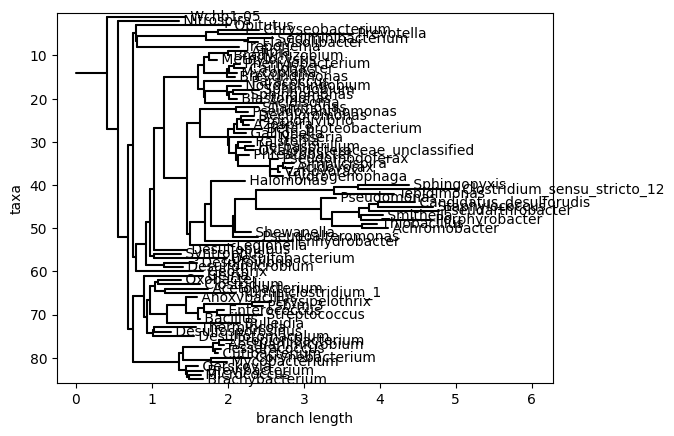

In [53]:
import io
# Create a tree object from the string
subtreeG_galaxy_string = Phylo.read(io.StringIO(subtreeG_galaxy), "newick")

# Create figure
plt.figure(figsize=(15, 25))  # Adjust size as needed
Phylo.draw(subtreeG_galaxy_string, do_show=True)
#t.savefig(input_dir / "simple_subtreeG_galaxy.png", dpi=300)
# plt.close()

### Anotation Function for Itol

In [62]:
def create_itol_barchart_file(aggregated_data, category_colors, categories, output_file, title="System Categories"):
    """
    Create iTOL multi-value bar chart data file from existing aggregated data

    Args:
        aggregated_data (dict): existing aggregated data dictionary
        category_colors (dict):  category color mappings
        categories (dict): category descriptions
        output_file (str): Path to save the iTOL annotation file
        title (str): Title for the dataset
    """
    # Convert hex colors to RGB values for iTOL
    def format_color(color):
        color = color.lower()
        if not color.startswith('#'):
            color = '#' + color
        return color

    # Color values need to be in hex format for iTOL
    formatted_colors = {k: format_color(v) for k, v in category_colors.items()}

    # Start building the file content
    lines = []

    # Add header with dataset information
    lines.append("DATASET_MULTIBAR")
    lines.append("SEPARATOR TAB")
    lines.append("DATASET_LABEL\tRelative Abundance by System Category")

    # Add color information for border
    lines.append("COLOR\t#000000")

    # Add field labels - use category descriptions
    field_labels = "\t".join([categories[cat_id] for cat_id in ['category_1', 'category_2', 'category_3']])
    lines.append(f"FIELD_LABELS\t{field_labels}")

    # Add field colors - use category colors
    field_colors = "\t".join([formatted_colors[cat_id] for cat_id in ['category_1', 'category_2', 'category_3']])
    lines.append(f"FIELD_COLORS\t{field_colors}")

    # Add additional formatting options that iTOL recognizes
    lines.append("MARGIN\t50")
    lines.append("WIDTH\t300")
    lines.append("HEIGHT_FACTOR\t0.8")

    # Start data section
    lines.append("DATA")

    # Add data for each genus using existing structure
    for genus, values in aggregated_data.items():

        # Skip if genus is a number
        if isinstance(genus, (int, float)) or (isinstance(genus, str) and genus.replace('.', '', 1).isdigit()):
            print(f"Skipping numeric genus identifier: {genus}")
            continue

        # Extract values for each category
        cat1 = values['category_1']
        cat2 = values['category_2']
        cat3 = values['category_3']

        # Only include genera with some data
        if cat1 > 0 or cat2 > 0 or cat3 > 0:
            lines.append(f"{genus}\t{cat1}\t{cat2}\t{cat3}")

    # Write to file
    with open(output_file, 'w', encoding= 'utf-8', newline='\n') as f:
        f.write("\n".join(lines))

    print(f"iTOL annotation file created at {output_file}")

# Define category colors with proper hex codes
category_colors = {
    'category_1': '#008800',  # Green
    'category_2': '#FF8C00',  # Orange
    'category_3': '#FF0000'   # Red
}

# Category descriptions
categories = {
    'category_1': 'Normal Operation',
    'category_2': 'Early Warning',
    'category_3': 'System Failure'
}


# Additionally, create a color strip annotation file for the bacterial sources
def create_itol_colorstrip_file(selected_taxa, output_file):
    """
    Create iTOL color strip annotation file for bacterial sources

    Args:
        selected_taxa (pd.DataFrame): DataFrame with taxa information including source
        output_file (str): Path to save the iTOL annotation file
    """
    # Define color mapping for bacterial sources
    source_colors = {
        'chk-core-us': '#4A0404',  # Deep burgundy for all three
        'chk-core': '#000033',     # Darker navy for checked+core
        'core-us': '#654321',      # Dark brown for core+usual
        'chk-us': '#9370DB',       # Purple for checked+usual
        'chk': '#000080',          # Navy blue for checked only
        'us': '#8B0000',           # Dark red for usual only
    }

    # Start building the file content
    lines = []

    # Add header with dataset information
    lines.append("DATASET_COLORSTRIP")
    lines.append("SEPARATOR TAB")
    lines.append("DATASET_LABEL\tBacterial Sources")

    # Add dataset scale factor
    lines.append("COLOR\t#000000")
    lines.append("WIDTH\t100")
    lines.append("MARGIN\t20")

    # Add legend information - correct iTOL format
    lines.append("LEGEND_TITLE\tSource Types")
    lines.append("LEGEND_SHAPES\t1\t1\t1\t1\t1\t1")
    lines.append("LEGEND_COLORS\t#4A0404\t#000033\t#654321\t#9370DB\t#000080\t#8B0000")
    lines.append("LEGEND_LABELS\tchk-core-us\tchk-core\tcore-us\tchk-us\tchk\tus")

    # Start data section
    lines.append("DATA")

    # Process each genus and its source - simplified approach
    for _, row in selected_taxa.iterrows():
        try:
            genus = row['Genus']
            if pd.isna(genus) or genus == "":
                continue

            source = "unknown"
            # Check if Source column exists and has a valid value
            if 'Source' in row and not pd.isna(row['Source']) and row['Source'] != "":
                source = str(row['Source']).lower()

            # Determine color based on source
            color = '#000000'  # Default black
            for src_type, src_color in source_colors.items():
                if src_type in source:
                    color = src_color
                    break

            # Write in proper iTOL format: NAME<tab>COLOR
            lines.append(f"{genus}\t{color}")
        except (IndexError, KeyError) as e:
            # Log errors but continue processing
            print(f"Error processing row: {e}")
            continue

    # Write to file - ensure proper line endings and encoding
    with open(output_file, 'w', encoding='utf-8', newline='\n') as f:
        f.write("\n".join(lines))

    print(f"iTOL color strip annotation file created at {output_file}")
    return output_file

# Additionally, here's a function to validate the colorstrip file format
def validate_colorstrip_file(file_path):
    """
    Check if colorstrip file follows proper iTOL format

    Args:
        file_path (str): Path to the iTOL colorstrip file

    Returns:
        bool: True if valid, False otherwise
    """
    required_headers = ["DATASET_COLORSTRIP", "SEPARATOR TAB", "DATA"]
    with open(file_path, 'r') as f:
        content = f.read()

    # Check for required headers
    for header in required_headers:
        if header not in content:
            print(f"Missing required header: {header}")
            return False

    # Check DATA section format
    data_section = content.split("DATA\n")[1] if "DATA\n" in content else ""
    if not data_section:
        print("No data found after DATA section")
        return False

    lines = data_section.strip().split("\n")
    for i, line in enumerate(lines, 1):
        if not line or line.isspace():
            continue
        if "\t" not in line:
            print(f"Line {i} in DATA section does not contain a tab separator: {line}")
            return False

        parts = line.split("\t")
        if len(parts) != 2:
            print(f"Line {i} in DATA section does not have exactly 2 tab-separated values: {line}")
            return False

        name, color = parts
        if not name or not color:
            print(f"Line {i} in DATA section has empty name or color: {line}")
            return False

        # Check if color is valid hex
        if color.startswith('#') and not all(c in "0123456789ABCDEFabcdef" for c in color[1:]):
            print(f"Line {i} has invalid hex color: {color}")
            return False

    print("Colorstrip file format appears valid")
    return True

In [63]:
# Annotated data to Create iTOL multi-value bar chart file
create_itol_barchart_file(
    aggregated_data,
    category_colors,
    categories,
    str(output_galaxy / "itol_abundance_bars.txt"),
    "Relative Abundance by System Category"
)

# Create iTOL color strip file for bacterial sources
create_itol_colorstrip_file(
    selected_taxa,
    str(output_galaxy / "itol_bacterial_sources.txt")
)

validate_colorstrip_file(str(output_galaxy / "itol_bacterial_sources.txt"))

iTOL annotation file created at /content/drive/MyDrive/MIC/data_qiime/output_galaxy/itol_abundance_bars.txt
iTOL color strip annotation file created at /content/drive/MyDrive/MIC/data_qiime/output_galaxy/itol_bacterial_sources.txt
Colorstrip file format appears valid


True